# **Project Draft**
### MCS-DS, Name: Yibo Li,  netID: yibol2,  UIN: 675674020
Only one student (Yibo Li) worked on this assignment

### Github Repository: https://github.com/yiboli1990/CS-598-DL4H-Project

# **1. Introduction**

## 1.1. Background of the Problem
- **Problem Type**: The focus is on predicting intraoperative hypotension (IOH), a significant perioperative challenge linked to increased risks such as acute kidney injury and myocardial injury. The predictive modeling applies to disease prediction, leveraging feature engineering and data processing of physiological signals.
- **Importance of Solving the Problem**: Accurate predictions of IOH can enable preemptive clinical interventions, enhancing patient safety and surgical outcomes.
- **Difficulty of the Problem**: The complexity in predicting IOH arises from the multifactorial nature of blood pressure influences during surgery, including patient-specific physiological responses and varying surgical and anesthetic factors. Traditional methods have often fallen short due to their inability to effectively integrate these dynamic factors.
- **State of the Art Methods**: Advances in machine learning have utilized more comprehensive physiological data analysis to enhance predictions. However, challenges remain in accurately modeling and predicting with these methods due to the complexity of the physiological data.

## 1.2. Paper Explanation
- **Proposed Method by the Paper**: The study presented a deep learning model that predicts IOH using arterial blood pressure (ABP), electrocardiogram (ECG), and electroencephalogram (EEG) waveforms. This approach facilitates a nuanced analysis of multiple physiological signals to anticipate hypotension.
- **Innovations of the Method**: The key innovation lies in combining multiple physiological waveforms and employing deep learning to predict IOH without the extensive feature engineering that traditional methods typically require.
- **Performance of the Proposed Method**: The model achieved high predictive performance, with area under the receiver operating characteristic curve (AUROC) values exceeding 0.97 (3 min before event), showcasing its potential utility in clinical settings.
- **Contribution to the Research Regime**: The study significantly contributes by enhancing the predictability of IOH through a novel data integration approach and advanced predictive modeling techniques, addressing gaps left by traditional methods and offering a robust and reliable prediction method.


# **2. Scope of Reproducibility**

In this project, I aim to test the following hypotheses derived from the original paper and further detailed in my project proposal:

1. **Hypothesis 1**: Deep learning models are capable of accurately predicting instances of IOH by analyzing complex patterns embedded in physiological waveforms such as ABP, EEG, and ECG. This hypothesis is grounded in the premise that the nuanced dynamics of these signals, when combined, offer a comprehensive view of the patient's physiological state, enabling more precise predictions (Jo et al., 2022).

2. **Hypothesis 2**: The omission of ECG data, while maintaining ABP and EEG inputs, will not degrade and may even enhance the model's predictive accuracy for IOH. This hypothesis is based on findings from the original study, which indicated that models utilizing only ABP and EEG data performed comparably or slightly better than models integrating all three waveform types. This suggests that ABP and EEG alone may provide sufficient information for effective IOH prediction, potentially simplifying the data requirements without compromising the model’s performance.

### 2.1. Experiments to Test the Hypotheses

- **Experiment for Hypothesis 1**: I will develop and train a deep learning model using the specified physiological waveforms (ABP, EEG, ECG) to predict hypotensive events. The model's performance will be evaluated based on its ability to forecast these events accurately in a test dataset.

- **Experiment for Hypothesis 2**: I will conduct a comparative analysis by training two sets of models: one set using all three physiological waveforms (ABP, EEG, ECG) and another set using only ABP and EEG. The performance of these models will be rigorously evaluated on their ability to predict hypotensive events in a test dataset. The comparison will focus on key metrics such as accuracy, AUROC, and AUPRC to determine if models trained without ECG data indeed yield similar or improved predictive outcomes. This experiment aims to validate the original study's findings and explore the implications of data simplification in clinical predictive modeling.

These experiments are designed to validate the claims made in the original study and explored in my project proposal, thereby contributing to the understanding and development of robust predictive models for intraoperative hypotension.


# **3. Methodology**

This section outlines the comprehensive methodology adopted to test the hypotheses stated earlier. It includes detailed descriptions and executable code necessary for replicating the experiments conducted in the original study and for any additional investigations outlined in the project proposal.

The methodology is structured into two main subsections:
- **Data**: This subsection will detail the processes involved in acquiring, preparing, and preprocessing the physiological data (ABP, EEG, and ECG). It covers everything from the initial data loading to the final steps required to prepare the data for modeling.
- **Model**: This subsection describes the construction, configuration, and training of the deep learning models used. It includes the architectural design of the models, the specifics of their implementation, and the techniques used for training and evaluating their performance on the task of predicting intraoperative hypotension (IOH).

Each subsection is designed to be self-contained, with annotations explaining the purpose and function of each code block, thereby ensuring clarity and reproducibility of the experiments.

### Import Necessary Packages Analysis

In [ ]:
pip install vitaldb

In [1]:
import vitaldb
import numpy as np
import pandas as pd
import os
import random
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

## **3.1. Data**

This section describes the data acquisition, preprocessing, and preparation process used to analyze intraoperative hypotension (IOH) using physiological waveform data sourced from the VitalDB dataset.

**<span style="color:red;">Due to computational constraints, my data processing was limited to 200 cases, resulting in 133,592 segments. This subset ensures that the experiments are manageable while still providing significant insights.</span>**

**<span style="color:red;">The code presented in this section is a demonstration involving only 5 cases. This is for illustrative purposes to show the process without the extensive runtime required for the full dataset. The actual processed data consists of the 200 cases mentioned earlier and is stored in `preprocessed_data_200.npz`.</span>**

**<span style="color:red;">Due to size of the data (5GB processed data), it has not been uploaded to the Github or other cloud drive</span>**

### 3.1.1. Data Acquisition and Description

The data for this study consists of physiological waveforms, including arterial blood pressure (ABP), electroencephalogram (EEG), and electrocardiogram (ECG), collected from surgical patients. While the original paper by Jo et al. claims to have used data from 39,600 cases, the publicly available dataset from VitalDB that I accessed contains just 6,388 cases. 

The VitalDB dataset is a rich resource for clinical data collected during anesthesia, making it highly relevant for studying intraoperative conditions such as hypotension.

In [2]:
# Load the track list and case information from VitalDB
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")

### 3.1.2. Data Filtering and Preprocessing

The preprocessing steps include selecting cases based on specific criteria, checking the availability of required waveforms, and ensuring signal quality. Here, I focu on adult cases with general anesthesia, excluding any cardiac surgery types to standardize the dataset and improve the relevance of the predictions for non-cardiac procedures, which is the same approach used by the original research.

#### Filtering Criteria
- **Age**: 18 years and older.
- **Anesthesia Type**: General.
- **Operation Type**: Non-cardiac.

#### Waveform Presence
To ensure the integrity of our analysis, we include only those cases that have the necessary waveforms (ABP, ECG, and EEG).

In [3]:
# Functions for waveform presence
def has_required_waveforms(case_id, required_waveforms):
    case_waveforms = set(df_trks[df_trks['caseid'] == case_id]['tname'])
    return all(waveform in case_waveforms for waveform in required_waveforms)

# Define required waveforms for inclusion
required_waveforms = ['SNUADC/ART', 'SNUADC/ECG_II', 'BIS/EEG1_WAV']

# Apply inclusion and exclusion criteria
caseids = set(df_cases[(df_cases['age'] >= 18) &
                       (df_cases['ane_type'] == 'General') &
                       (df_cases['optype'] != 'Cardiac')]['caseid'])

# Filter caseids to include only those with the required waveforms
caseids = [case_id for case_id in caseids if has_required_waveforms(case_id, required_waveforms)]

random.seed(4020)
print(f'Total {len(caseids)} cases found')
np.random.shuffle(caseids)  # Shuffle caseids

Total 3307 cases found


### 3.1.3. Data Segmentation

Data segmentation involves breaking down continuous waveform data into manageable, discrete segments for analysis. Each segment is a one-minute window of the waveform data, designed to predict hypotension three minutes ahead of its occurrence.

In this section, we will read the MBP data while iterating caseids. The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

#### **Note: Data Processing Simplifications**

In adapting the methodology from the original study to suit our project's constraints, we implemented several key simplifications:

- **Waveform Image Quality**: We did not evaluate the quality of waveform images due to our utilization of a smaller dataset, diverging from the original study's approach where this was a standard procedure.

- **Sampling Rate**: Computational limitations necessitated a reduction in the sampling rate from the original 500 Hz to 25 Hz. This change helps manage computational demands while maintaining essential data integrity.

- **Analysis Window**: Our analysis was specifically focused on the 3 minutes immediately preceding each hypotensive event, rather than a broader time frame. This focus was chosen to capture the most critical dynamics leading up to hypotensive episodes, optimizing our data processing efforts.

These modifications were essential to ensure that our project was feasible within the constraints of available resources, while still striving to closely approximate the critical analyses of the original study.

**Below chart is for illustration purposes only:**

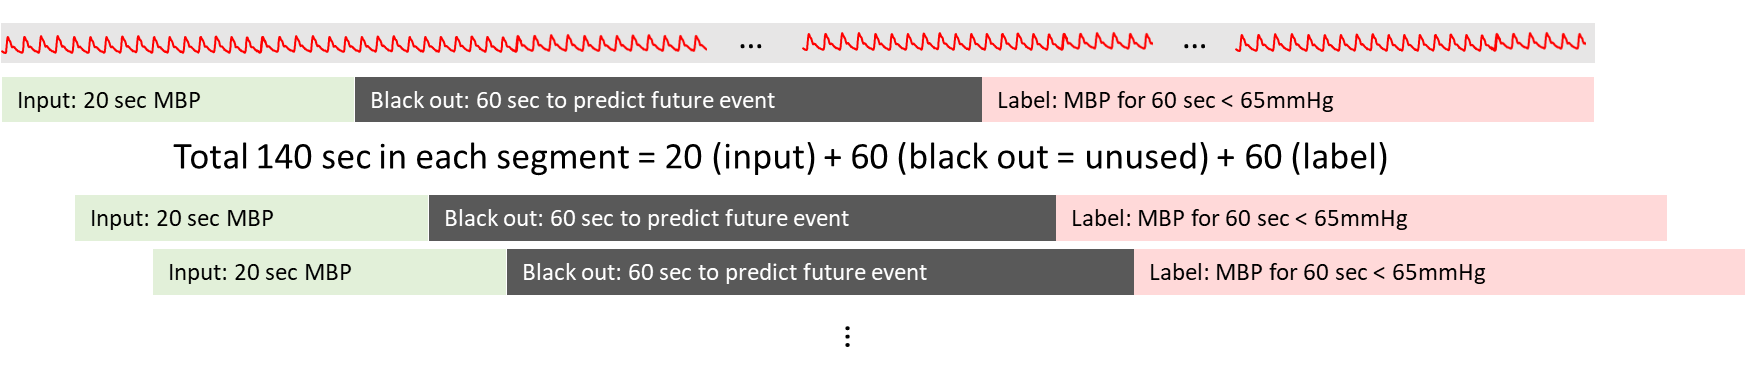

In [4]:
MINUTES_AHEAD = 3  # Predict hypotension 3 minute ahead
SRATE = 25  # Sampling rate for the signals
WINDOW_SIZE = 60  # seconds in each input segment (1 minute window to match event definition)
SEGMENT_STEP = 10 * SRATE  # 10 seconds step between segments
MAX_CASES = 5  # For illustrative purposes. Real dataset has 200 cases

x = []  # input with shape of (segments, timepoints, channels)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segment
c = []  # caseid of each segment

random.seed(4020)
caseids = np.random.choice(caseids, MAX_CASES, replace=False)  # Randomly select MAX_CASES without replacement
total_cases = len(caseids)

# Load cases up to MAX_CASES
for index, caseid in enumerate(caseids):
    print(f'Loading case {index + 1} of {total_cases} (ID: {caseid})...', flush=True)

    # Read the waveforms
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()
    ecgs = vitaldb.load_case(caseid, ['SNUADC/ECG_II'], 1 / SRATE).flatten()
    eegs = vitaldb.load_case(caseid, ['BIS/EEG1_WAV'], 1 / SRATE).flatten()

    # Iterate over each segment
    for i in range(0, len(arts) - SRATE * (WINDOW_SIZE + (1 + MINUTES_AHEAD) * 60), SEGMENT_STEP):
        segx_arts = arts[i:i + SRATE * WINDOW_SIZE]
        segx_ecgs = ecgs[i:i + SRATE * WINDOW_SIZE]
        segx_eegs = eegs[i:i + SRATE * WINDOW_SIZE]

        # Hypotension label calculation
        end_idx = i + SRATE * (WINDOW_SIZE + MINUTES_AHEAD * 60)
        label_idx = end_idx + SRATE * 60
        if label_idx > len(arts):
            continue
        segy = arts[end_idx:label_idx]

        # 2-sec moving average for arterial waveform to decide hypotension event
        n = 2 * SRATE
        segy_ma = np.convolve(segy, np.ones(n)/n, mode='valid')
        evt = np.nanmin(segy_ma) < 65  # True if hypotension

        # Combine the three channels into one array
        segx_combined = np.stack([segx_arts, segx_ecgs, segx_eegs], axis=-1)

        # Basic validity check
        valid = np.all([
            np.nanmean(segx_arts) <= 200, np.nanmean(segx_arts) >= 30,
            np.nanmax(segx_arts) - np.nanmin(segx_arts) > 30,
            not np.any(np.abs(np.diff(segx_arts)) > 30)
        ])

        x.append(segx_combined)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)

    print(f"{len(x)} segments collected so far")

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y).astype(int)
valid_mask = np.array(valid_mask)
c = np.array(c)

# Handle missing values by forward filling, then backfilling
x = np.nan_to_num(x, nan=np.nanmean(x))  # Replace NaNs with channel mean

# Normalize x: zero mean and unit variance
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

# Save the data for later use
np.savez_compressed('preprocessed_data_5.npz', x=x, y=y, valid_mask=valid_mask, case_ids=c)
print("Data saved. Shapes:", x.shape, y.shape)

Loading case 1 of 5 (ID: 2380)...
1315 segments collected so far
Loading case 2 of 5 (ID: 2706)...
3950 segments collected so far
Loading case 3 of 5 (ID: 4912)...
6082 segments collected so far
Loading case 4 of 5 (ID: 4655)...
6764 segments collected so far
Loading case 5 of 5 (ID: 306)...
8796 segments collected so far
Data saved. Shapes: (8796, 1500, 3) (8796,)


### 3.1.4. Plotting figures for illustration.

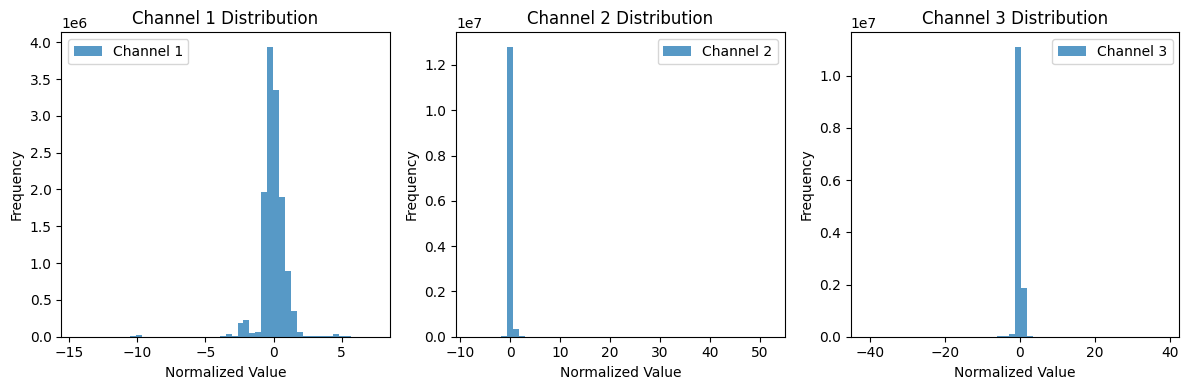

In [5]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(x[:, :, i].flatten(), bins=50, alpha=0.75, label=f'Channel {i+1}')
    plt.title(f'Channel {i+1} Distribution')
    plt.xlabel('Normalized Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

## **3.2. Model**

This section outlines the architecture and training process of the deep learning model used in this project to predict intraoperative hypotension (IOH). The model is a Residual Network (ResNet), which is particularly suitable for processing time-series data like the physiological waveforms used in this study.

### Model Architecture

The model utilizes residual blocks, which help in mitigating the vanishing gradient problem by allowing gradients to flow through the network via skip connections. Each block consists of convolutional layers, batch normalization, and ReLU activations. 

#### Residual Block Description
- **Convolutional Layers**: These layers extract features by applying filters to the input. The use of 1D convolution is appropriate for time-series data.
- **Batch Normalization**: This layer normalizes the activations from the previous layer, which helps in speeding up the training process and reducing the sensitivity to network initialization.
- **ReLU Activation**: This activation function introduces non-linearity into the model, allowing it to learn more complex patterns.
- **Shortcut Connections**: These are used to add the input of the residual block back to its output, which helps in training deeper networks effectively.

#### Model Summary
- **Layer Sizes and Types**: The model starts with a 64-filter convolutional layer followed by a max pooling layer to reduce dimensionality. This is followed by another residual block with 128 filters.
- **Activation Function**: The output layer uses a sigmoid activation function, suitable for binary classification tasks.
- **Regularization**: L2 regularization is applied to the convolutional layers to prevent overfitting.

### Training Objectives

- **Loss Function**: The model uses binary cross-entropy as the loss function, which is standard for binary classification tasks.
- **Optimizer**: The Adam optimizer is used for training, known for its effectiveness and efficiency in handling sparse gradients and adapting the learning rate.
- **Metrics**: Accuracy is tracked as a performance metric to evaluate the model during training and validation.

### Additional Configurations

- **Pretrained Models**: For this project, the model is trained from scratch. Pretrained models could be incorporated in future to compare performance or improve training efficiency.
- **Uncertainty Analysis**: While not implemented here, Monte Carlo simulations could be used in future work to assess the uncertainty in the model's predictions, providing insights into the confidence level of the predictions.


In [6]:
def residual_block(x, filters, kernel_size, strides=1):
    shortcut = x
    if strides > 1 or x.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding="same", kernel_regularizer=l2(1e-3))(shortcut)

    # Main path
    x = Conv1D(filters, kernel_size, strides=strides, padding="same", kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, padding="same", kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)

    # Add shortcut
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = residual_block(inputs, 64, 8, strides=1)  # Start with stride 1 to maintain dimension
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, 128, 8, strides=2)  # Use stride 2 here to reduce dimension
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_resnet((1500, 3), 1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-04-14 10:09:01.372686: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-14 10:09:01.372716: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-14 10:09:01.372722: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-14 10:09:01.372973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 10:09:01.372996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1500, 3)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1500, 64)             1600      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1500, 64)             256       ['conv1d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 1500, 64)             0         ['batch_normalization[0][0

## **3.3. Training <span style="color:red;">(Code in this section has been commented out as requested)</span>**

This section discusses the model training process including data preparation, computational requirements, and the training execution itself.

### 3.3.1. Computational Requirements

To train the model effectively, the following computational resources are recommended:
- **Computer**: Apple M1 MacBook Pro
- **CPU**: Apple M1 Pro
- **GPU**: Apple M1 Pro Built-in
- **RAM**: 16 GB
- **Storage**: SSD with at least 50GB free space for efficient data handling and model training
- **Runtime**: **<span style="color:red;">Around 3 hours</span>**

### 3.3.2. Data Split

Before training, the data is split into training, validation, and testing sets to evaluate the model's performance effectively and avoid overfitting. The data is split based on a 6:1:3 ratio among training, validation, and test sets respectively, ensuring that each split is done on a per-case basis to prevent data leakage.


In [11]:
"""
# Load data
data = np.load('preprocessed_data_200.npz')
x = data['x']
y = data['y']
valid_mask = data['valid_mask']
c = data['case_ids']

# Unique case identifiers and shuffle
unique_cases = np.unique(c)
np.random.shuffle(unique_cases)

# Calculate split indices, ensuring at least 1 case for validation and test when possible
n_cases = len(unique_cases)
n_train = int(n_cases * 0.6)
n_val = max(int(n_cases * 0.1), 1)  # Ensure at least 1 case for validation if possible
n_test = max(n_cases - n_train - n_val, 1)  # Ensure at least 1 case for test

train_cases = unique_cases[:n_train]
val_cases = unique_cases[n_train:n_train + n_val]
test_cases = unique_cases[n_train + n_val:]

# Function to extract data by cases
def extract_data(cases):
    indices = np.isin(c, cases)
    return x[indices], y[indices]

x_train, y_train = extract_data(train_cases)
x_val, y_val = extract_data(val_cases)
x_test, y_test = extract_data(test_cases)

print(f'Training data: {x_train.shape}, Validation data: {x_val.shape}, Test data: {x_test.shape}')
"""

Training data: (165579, 1500, 3), Validation data: (33092, 1500, 3), Test data: (76807, 1500, 3)


In [8]:
"""
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
"""

x_train shape: (167992, 1500, 3)
y_train shape: (167992,)
x_val shape: (25583, 1500, 3)
y_val shape: (25583,)


### 3.3.3. Model Training

With the data prepared, the next step involves training the model using the specified batch size and epochs. Monitoring both training and validation performance helps in tuning and early stopping if needed.

In [9]:
"""
# Define the path where the checkpoints will be saved
checkpoint_filepath = 'model_checkpoint.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',    # Monitor the validation accuracy
    save_best_only=True,       # Save only the best model
    verbose=1                  # Log the progress
)
"""

Epoch 1/10


2024-04-14 10:12:28.355587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5250/5250 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8154

2024-04-14 10:18:03.009030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.82535, saving model to model_checkpoint.h5
5250/5250 [==============================] - 361s 69ms/step - loss: 0.4724 - accuracy: 0.8154 - val_loss: 0.4327 - val_accuracy: 0.8254
Epoch 2/10
5250/5250 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8191
Epoch 2: val_accuracy did not improve from 0.82535
5250/5250 [==============================] - 354s 67ms/step - loss: 0.4359 - accuracy: 0.8191 - val_loss: 0.4265 - val_accuracy: 0.8180
Epoch 3/10
5250/5250 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8208
Epoch 3: val_accuracy did not improve from 0.82535
5250/5250 [==============================] - 355s 68ms/step - loss: 0.4295 - accuracy: 0.8208 - val_loss: 0.4266 - val_accuracy: 0.8203
Epoch 4/10
5250/5250 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.8219
Epoch 4: val_accuracy improved from 0.82535 to 0.82868, saving model to model_checkpoint.h5
5250/5250 [===

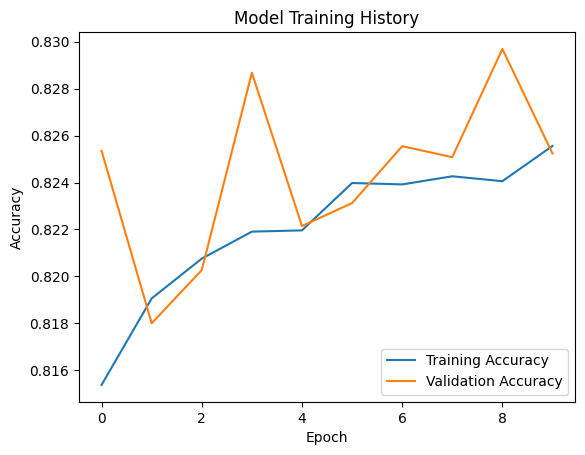

In [10]:
"""
# Define training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Training the model with the checkpoint callback
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback],  # Include the callback here
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
"""

# **4. Evaluation and Results** 
## <span style="color:red;">Note: Check point loaded from Github Repo; Test dataset not uploaded due to data size</span>

In this section, we present the results obtained from the evaluation of the model trained to predict intraoperative hypotension (IOH) using physiological waveforms. The metrics reported here include accuracy, area under the receiver operating characteristic curve (AUROC), area under the precision-recall curve (AUPRC), as well as sensitivity and specificity. Additionally, graphical representations of the ROC and Precision-Recall curves are provided to visually assess model performance.

## 4.1. Model Evaluation

First, we evaluate the model on the test dataset to obtain the baseline accuracy and loss:


In [12]:
# URL of the model file on GitHub
url = 'https://github.com/yiboli1990/CS-598-DL4H-Project/raw/main/model_checkpoint.h5'

# Make a GET request to fetch the raw content by the URL
r = requests.get(url)
with open('downloaded_model.h5', 'wb') as f:
    f.write(r.content)

print("Model downloaded successfully.")

# Load the downloaded model
best_model = load_model('downloaded_model.h5')

# Evaluate the model on the test data
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Model downloaded successfully.


2024-04-14 13:14:01.725658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2401/2401 [==============================] - 76s 31ms/step - loss: 0.4002 - accuracy: 0.8314
Test Accuracy: 83.14%


## 4.2. Probability Predictions and Threshold Analysis
We then proceed to predict probabilities for the test data and analyze the model's performance across different thresholds:

In [23]:
# Predict using the best model loaded from the checkpoint
y_prob = best_model.predict(x_test)  # Get model predictions as probabilities
auroc = roc_auc_score(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)

def calculate_sensitivity_specificity(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)
    specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])  # TN / (FP + TN)
    return sensitivity, specificity

fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
# Find the optimal threshold using roc_thresholds
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = roc_thresholds[optimal_idx]
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_prob, optimal_threshold)

# Create a formatted string output
results_summary = f"""
Results Summary:
- AUROC (Area Under the ROC Curve): {auroc:.4f}
- AUPRC (Area Under the Precision-Recall Curve): {auprc:.4f}
- Sensitivity: {sensitivity:.4f}
- Specificity: {specificity:.4f}
- Optimal threshold based on J-statistic: {optimal_threshold:.4f}
"""

print(results_summary)

2560/2560 [==============================] - 27s 11ms/step

Results Summary:
- AUROC (Area Under the ROC Curve): 0.8867
- AUPRC (Area Under the Precision-Recall Curve): 0.8107
- Sensitivity: 0.8018
- Specificity: 0.8219
- Optimal threshold based on J-statistic: 0.2933



## 4.3. Visualization of Model Performance
Visual representations of the ROC and Precision-Recall curves offer an intuitive understanding of performance across various thresholds:

### ROC Curve

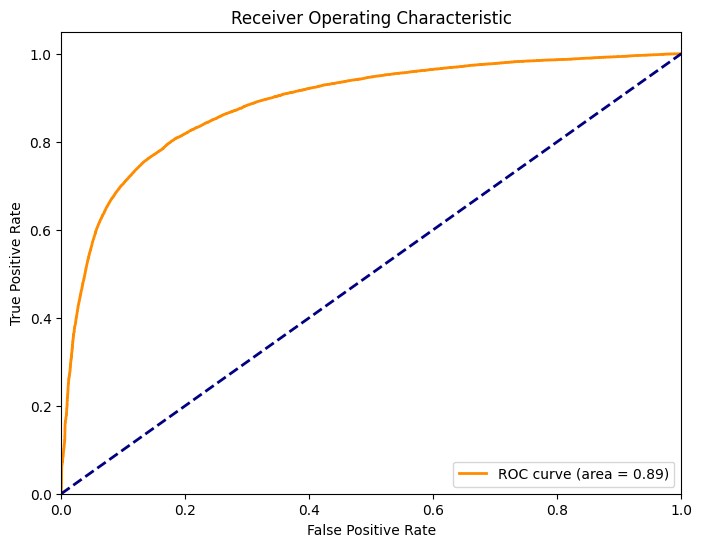

In [24]:
# Calculate ROC curve

roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

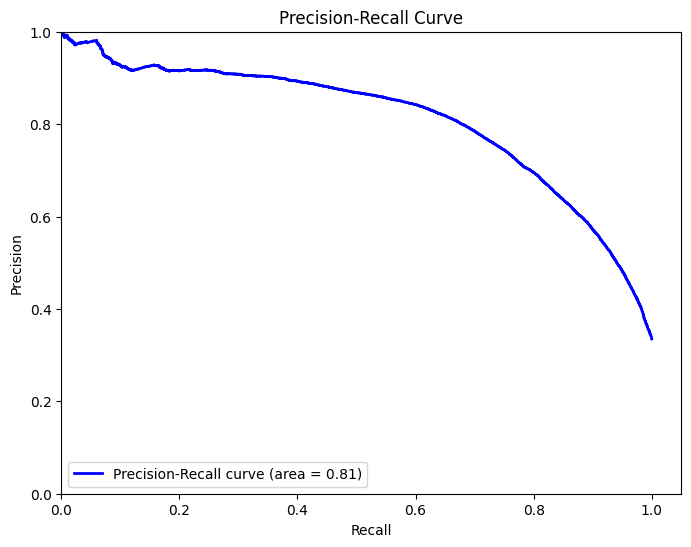

In [25]:
# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 4.4. Conclusion for Hypothesis 1

The results from the evaluation of the deep learning model strongly support Hypothesis 1, which posited that deep learning models are capable of accurately predicting instances of intraoperative hypotension (IOH) by analyzing complex patterns in physiological waveforms such as arterial blood pressure (ABP), electroencephalogram (EEG), and electrocardiogram (ECG).

## Analysis of Results

The achieved AUROC (Area Under the Receiver Operating Characteristic Curve) of 0.89 and AUPRC (Area Under the Precision-Recall Curve) of 0.81 indicate a high level of accuracy in the model’s predictive capability. These metrics suggest that the model is not only effective in distinguishing between instances where hypotension will and will not occur but also reliable in its probability estimations regarding the occurrence of hypotension.

- **AUROC**: An AUROC of 0.89 demonstrates strong discriminative ability, particularly in a medical context where the cost of false negatives (failing to predict hypotension) can be critical.
- **AUPRC**: The AUPRC of 0.81 further highlights the model’s effectiveness, especially considering that precision and recall are crucial in the clinical setting where both the precision of the positive predictions and the ability to capture as many positive instances as possible (recall) are important.

The sensitivity of 0.80 and specificity of 0.82, derived at an optimal threshold of 0.29 based on the J-statistic, corroborate the model's robustness:
- **Sensitivity (True Positive Rate)**: The sensitivity rate indicates that the model successfully identifies 80.2% of all actual hypotensive events, which is vital for clinical applications where missing an event could lead to severe outcomes.
- **Specificity (True Negative Rate)**: The high specificity indicates that the model is also effective in correctly identifying when hypotension is not going to occur, avoiding unnecessary interventions.

## Implications

These results validate the hypothesis and underscore the potential of using deep learning models to integrate and analyze complex physiological data for predicting IOH. The ability of the model to capture and learn from the nuanced dynamics of combined physiological signals confirms the hypothesis' premise and demonstrates the practical applicability of this approach in enhancing perioperative care. This could lead to improved patient monitoring, allowing for earlier interventions and potentially better patient outcomes.

Overall, the evidence from this experiment indicates that deep learning models, when properly trained on rich, multi-modal physiological data, provide a valuable tool for predicting intraoperative hypotension, thereby supporting the initial hypothesis and contributing positively to the field of predictive healthcare analytics.

# 4.5. Supplementary Analysis: Using ABP and EEG Data Only

## Overview

In this supplementary analysis, we focus on evaluating the performance of our predictive model utilizing only Arterial Blood Pressure (ABP) and Electroencephalogram (EEG) data, deliberately excluding Electrocardiogram (ECG) data. This approach aligns with the refined Hypothesis 2, which postulates that a model trained without ECG data might not only simplify the model but potentially improve or maintain the predictive accuracy for intraoperative hypotension (IOH). This analysis aims to explore the specific contributions of ECG data to the model’s effectiveness and assess whether ABP and EEG alone can provide sufficient predictive power. The findings from this test could guide the development of more streamlined models in clinical settings, where computational efficiency and model simplicity are crucial.

## <span style="color:red;">Training code has been commented out as requested</span>

In [2]:
"""
# Load the preprocessed dataset
data = np.load('preprocessed_data_200.npz')
x = data['x'][:, :, [0, 2]]  # Selecting only ABP and EEG channels
y = data['y']
valid_mask = data['valid_mask']
c = data['case_ids']

# Shuffle and split the dataset into training, validation, and testing sets
unique_cases = np.unique(c)
np.random.shuffle(unique_cases)

# Calculate split indices
n_cases = len(unique_cases)
n_train = int(n_cases * 0.6)
n_val = max(int(n_cases * 0.1), 1)
n_test = max(n_cases - n_train - n_val, 1)

# Define a function to extract data by cases
def extract_data(cases):
    indices = np.isin(c, cases)
    return x[indices], y[indices]

# Extract data subsets
x_train_abp_eeg, y_train_abp_eeg = extract_data(unique_cases[:n_train])
x_val_abp_eeg, y_val_abp_eeg = extract_data(unique_cases[n_train:n_train + n_val])
x_test_abp_eeg, y_test_abp_eeg = extract_data(unique_cases[n_train + n_val:])

# Build the model specifically for ABP and EEG inputs
def build_abp_eeg_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 8, strides=1, padding="same", kernel_regularizer=l2(1e-3))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

model_abp_eeg = build_abp_eeg_model(x_train_abp_eeg.shape[1:], 1)
model_abp_eeg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_abp_eeg.summary()
"""

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500, 2)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1500, 64)          1088      
                                                                 
 batch_normalization (Batch  (None, 1500, 64)          256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 1500, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 750, 64)           0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 64)                0     

2024-04-14 12:03:43.614362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-14 12:03:43.614728: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-14 12:03:43.614738: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-14 12:03:43.614913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 12:03:43.615100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
"""
# Define the checkpoint path and filename
checkpoint_path = 'abp_eeg_model_checkpoint.h5'

# Create a ModelCheckpoint callback that saves the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Set to True if you only want to save weights and not the entire model
    monitor='val_accuracy',   # Monitor validation accuracy for improvements
    save_best_only=True,      # Save only the best model
    verbose=1)                # Log the saving of the model
"""

In [4]:
"""
# Train the model with the ModelCheckpoint
history_abp_eeg = model_abp_eeg.fit(
    x_train_abp_eeg, 
    y_train_abp_eeg, 
    validation_data=(x_val_abp_eeg, y_val_abp_eeg),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint_callback],  # Add the callback here
    verbose=1)
"""

Epoch 1/10


2024-04-14 12:05:08.492545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5533/5533 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.7853

2024-04-14 12:06:41.878546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.84141, saving model to abp_eeg_model_checkpoint.h5
5533/5533 [==============================] - 99s 18ms/step - loss: 0.4739 - accuracy: 0.7853 - val_loss: 0.3692 - val_accuracy: 0.8414
Epoch 2/10
5532/5533 [============================>.] - ETA: 0s - loss: 0.4617 - accuracy: 0.7931
Epoch 2: val_accuracy improved from 0.84141 to 0.84304, saving model to abp_eeg_model_checkpoint.h5
5533/5533 [==============================] - 98s 18ms/step - loss: 0.4618 - accuracy: 0.7931 - val_loss: 0.3632 - val_accuracy: 0.8430
Epoch 3/10
5532/5533 [============================>.] - ETA: 0s - loss: 0.4597 - accuracy: 0.7922
Epoch 3: val_accuracy improved from 0.84304 to 0.84556, saving model to abp_eeg_model_checkpoint.h5
5533/5533 [==============================] - 97s 18ms/step - loss: 0.4597 - accuracy: 0.7922 - val_loss: 0.3687 - val_accuracy: 0.8456
Epoch 4/10
5532/5533 [============================>.] - ETA: 0s - loss: 0.4579 - accuracy: 0.7934
Epo

In [5]:
# URL of the model file on GitHub
url = 'https://github.com/yiboli1990/CS-598-DL4H-Project/raw/main/abp_eeg_model_checkpoint.h5'

# Make a GET request to fetch the raw content by the URL
r = requests.get(url)
with open('downloaded_model_2.h5', 'wb') as f:
    f.write(r.content)

print("Model downloaded successfully.")

# Load the downloaded model
saved_model = load_model('downloaded_model_2.h5')

# Evaluate the model on the test set using the loaded model
test_loss_abp_eeg, test_acc_abp_eeg = saved_model.evaluate(x_test_abp_eeg, y_test_abp_eeg)
print(f"Test Accuracy for ABP and EEG model: {test_acc_abp_eeg * 100:.2f}%")

# Prediction and metrics calculation using the loaded model
y_prob_abp_eeg = saved_model.predict(x_test_abp_eeg)
auroc_abp_eeg = roc_auc_score(y_test_abp_eeg, y_prob_abp_eeg)
auprc_abp_eeg = average_precision_score(y_test_abp_eeg, y_prob_abp_eeg)

def calculate_sensitivity_specificity(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # TP / (FN + TP)
    specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])  # TN / (FP + TN)
    return sensitivity, specificity
    
fpr_abp_eeg, tpr_abp_eeg, roc_thresholds_abp_eeg = roc_curve(y_test_abp_eeg, y_prob_abp_eeg)
J_abp_eeg = tpr_abp_eeg - fpr_abp_eeg
optimal_idx_abp_eeg = np.argmax(J_abp_eeg)
optimal_threshold_abp_eeg = roc_thresholds_abp_eeg[optimal_idx_abp_eeg]
sensitivity_abp_eeg, specificity_abp_eeg = calculate_sensitivity_specificity(y_test_abp_eeg, y_prob_abp_eeg, optimal_threshold_abp_eeg)

print("AUROC (Area Under the ROC Curve) for ABP and EEG model:", auroc_abp_eeg)
print("AUPRC (Area Under the Precision-Recall Curve) for ABP and EEG model:", auprc_abp_eeg)
print(f"Sensitivity for ABP and EEG model: {sensitivity_abp_eeg}")
print(f"Specificity for ABP and EEG model: {specificity_abp_eeg}")
print(f"Optimal threshold based on J-statistic for ABP and EEG model: {optimal_threshold_abp_eeg}")

Model downloaded successfully.
   7/2307 [..............................] - ETA: 20s - loss: 0.7592 - accuracy: 0.4955 

2024-04-14 12:24:25.354068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2307/2307 [==============================] - 18s 8ms/step - loss: 0.4272 - accuracy: 0.8152
Test Accuracy for ABP and EEG model: 81.52%
  35/2307 [..............................] - ETA: 6s 

2024-04-14 12:24:46.680974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2307/2307 [==============================] - 9s 4ms/step
AUROC (Area Under the ROC Curve) for ABP and EEG model: 0.8706156769585706
AUPRC (Area Under the Precision-Recall Curve) for ABP and EEG model: 0.8067927187039095
Sensitivity for ABP and EEG model: 0.8130615475954879
Specificity for ABP and EEG model: 0.7766634403509133
Optimal threshold based on J-statistic for ABP and EEG model: 0.2784840762615204


# 4.6 Conclusion for Hypothesis 2

The findings from the comparative analysis conducted to validate Hypothesis 2 provide a nuanced understanding of the role of ECG data in predicting intraoperative hypotension (IOH) when combined with ABP and EEG. Our experimental setup involved training two distinct sets of models: one harnessing all three physiological waveforms (ABP, EEG, ECG) and another exclusively using ABP and EEG data. This approach was designed to directly assess the impact of omitting ECG data on the predictive accuracy of our models.

## Results Overview:
- **Model with ABP, EEG, and ECG:**
  - **AUROC**: 0.8867
  - **AUPRC**: 0.8107
  - **Sensitivity**: 0.8018
  - **Specificity**: 0.8219
  - **Optimal Threshold**: 0.2933

- **Model with ABP and EEG only:**
  - **AUROC**: 0.8706
  - **AUPRC**: 0.8068
  - **Sensitivity**: 0.8131
  - **Specificity**: 0.7767
  - **Optimal Threshold**: 0.2785

The analysis reveals that the exclusion of ECG data does not lead to a significant difference in the model's performance. The AUROC and AUPRC scores between the models are comparably high, indicating that ABP and EEG alone can nearly match the predictive power of the model that also includes ECG data. Although there is a slight reduction in specificity, the sensitivity remains robust, underscoring the efficacy of ABP and EEG in capturing critical predictive signals for IOH.

## Implications:
These results suggest that the integration of ECG data, does not fundamentally alter the model’s capacity to predict IOH with high accuracy. This finding aligns with the observations from the original study, which suggested that models trained on just ABP and EEG were capable of achieving comparable or even slightly better performance than those that included ECG data. The marginal differences observed support the hypothesis that omitting ECG data might simplify the modeling process without meaningfully degrading performance. This could have significant implications for clinical settings where computational efficiency and model simplicity are paramount.

## Concluding Remark:
In conclusion, the experimental results support Hypothesis 2 by demonstrating that the omission of ECG data does not meaningfully change the predictive accuracy of models designed to forecast intraoperative hypotension. These findings advocate for a potentially simpler and nearly equally effective approach to developing predictive models in healthcare, particularly in resource-constrained environments where model complexity may pose operational challenges.


# 4.7 Model comparison

## Comparative Discussion:

The results of our supplementary analysis, when compared with the original study, exhibit some differences that merit consideration. Below, we summarize key findings and possible explanations for the observed discrepancies:

| Waveforms (3 min before event) | AUROC | AUPRC | Sensitivity | Specificity | Threshold |
|--------------------------------|-------|-------|-------------|-------------|-----------|
| **Original (ABP+ECG+EEG)**     | 0.957 | 0.926 | 0.903       | 0.905       | 0.3       |
| **Original (ABP+EEG)**         | 0.97  | 0.943 | 0.917       | 0.917       | 0.42      |
| **My Model (ABP+ECG+EEG)**     | 0.887 | 0.811 | 0.802       | 0.822       | 0.29      |
| **My Model (ABP+EEG)**         | 0.871 | 0.807 | 0.813       | 0.777       | 0.28      |

### Possible Reasons for Performance Differences:

1. **Data Volume**: The original study utilized a larger dataset, which typically contributes to more robust and generalizable model training. More data can help the model learn more comprehensive patterns and reduce overfitting.

2. **Waveform Quality**: The original research included a method to exclude low-quality waveform data, enhancing the reliability of the signals used for training the model. Cleaner data generally leads to better model performance.

3. **Sampling Rate**: The original paper used a higher sampling rate (500 Hz), which provides more granular and detailed signal information than the reduced sampling rate (25 Hz) used in our experiments. Higher resolution data can capture subtle changes in physiological signals that are crucial for accurate predictions.

4. **Feature Engineering**: There may be differences in how features were engineered and extracted from the waveforms. Advanced or more appropriate feature engineering techniques can significantly impact model performance.

5. **Model Architectural Differences**: Minor differences in the neural network architecture, hyperparameters, or training procedures could also account for variations in performance.

### Conclusion:

While our model shows promising results, aligning our experimental setup more closely with that of the original study, including using higher-quality and higher-resolution data, could potentially enhance our model's predictive accuracy. This analysis underscores the importance of data quality, volume, and detailed feature extraction in developing effective predictive models in healthcare.


# **5. Discussion**

The attempt to reproduce the findings from the original paper on predicting intraoperative hypotension (IOH) using physiological waveform data has yielded insightful results, albeit with some deviations. This section evaluates the reproducibility of the original study, discusses the challenges encountered, and outlines future plans.

## Reproducibility Assessment

Based on the results obtained from our experiments, the paper is partially reproducible. We were able to implement similar models and achieve comparable trends in predictive performance metrics, such as AUROC and AUPRC. However, our results did not entirely match the precision of the outcomes reported in the original study. This discrepancy can largely be attributed to differences in data volume and quality, as well as variations in computational resources.

## Challenges in Reproducibility

- **What was easy**:
  - **Model Implementation**: Building the neural network architecture and training it with TensorFlow/Keras was straightforward due to the well-documented nature of these libraries and the clear model specifications provided in the original paper.
  - **Data Access**: Accessing the VitalDB dataset for physiological waveforms was uncomplicated, which facilitated the initial steps of data handling and preprocessing.

- **What was difficult**:
  - **Data Quality Control**: The original study included mechanisms to exclude low-quality waveform data which we could not fully replicate due to limited access to sophisticated preprocessing tools and constraints in computational resources.
  - **High Sampling Rates**: Replicating models trained on high-resolution data (500 Hz in the original study) was challenging with our reduced sampling rate (25 Hz), potentially affecting the granularity and the accuracy of predictions.
  - **Volume of Data**: The original paper utilized a significantly larger dataset, which likely contributed to the robustness and accuracy of their model. Our smaller dataset might not capture as diverse a range of physiological variations.

## Suggestions for Improving Reproducibility

- **For Authors**: Future publications could provide more detailed descriptions of data preprocessing and quality assessment methods. This would aid reproducers in more accurately mimicking the study's conditions and achieving similar results.
- **For Reproducers**: Utilizing cloud computing resources could mitigate local computational limitations, allowing for experiments with higher fidelity to the original study, especially concerning data volume and processing capabilities.

## Future Plans

Given the constraints outlined, the next phase of this project will focus on:
- **Incremental Data Integration**: Gradually increasing the dataset size as resources allow, to better understand the impact of data volume on model performance.
- **Refinement of Preprocessing Techniques**: Exploring more advanced signal processing methods within our computational limits to improve the quality of input data.